In [ ]:
!pip3 install matplotlib
!pip3 install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
!pip3 install numpy
!pip3 install nest_asyncio
!pip3 install networkx

In [3]:
import json
import twint
import nest_asyncio
from collections import Counter
import pandas as pd
pd.set_option('display.max_colwidth', 0)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import networkx as nx
from pandas import Grouper
from pylab import rcParams

# File path

In [4]:
file_path = "../data/twint/2019_#uberlyftstrike_april_and_may.txt"

# Read in the tweets

In [5]:
tweets = []
with open(file_path) as f:
    for line in f:
        tweet = json.loads(line)
        tweets.append(tweet)
                                  
print("Total number of tweets: %d" % len(tweets))

Total number of tweets: 4337


## 1. Get most popular Uber-related hashtags

### Hashtags and their occurrences

Total number of tweets: 4337
Number of tweets without hashtags: 0


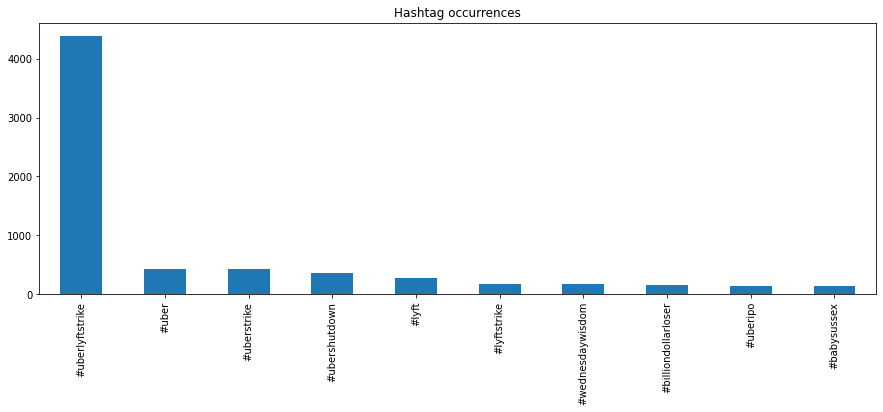

In [6]:
all_hashtags = []
hashtag_pairs = []
tweets_without_hashtags = []
for t in tweets:
    hashtags = t['hashtags']
    pairs = combinations(hashtags, r=2)
    for pair in pairs:
        hashtag_pairs.append(pair)
    for h in hashtags:
        all_hashtags.append(h)
    if len(hashtags) == 0:
        tweets_without_hashtags.append(tweet)
                                  
print("Total number of tweets: %d" % len(tweets))
print("Number of tweets without hashtags: %d" % len(tweets_without_hashtags))
hashtags_counter = Counter(all_hashtags)
hashtag_count_df = pd.DataFrame.from_dict(hashtags_counter, orient='index', columns=['count']).sort_values(by=['count'], ascending=False).head(10)
hashtag_count_df.plot(kind='bar', legend=False, title='Hashtag occurrences', figsize=(15, 5))
plt.show()

### Hashtag co-ocurrences

In [ ]:
pairs_counter = Counter(hashtag_pairs)

hashtags_in_most_common_pairs = []
for t in pairs_counter.most_common(20):
    hashtags_in_most_common_pairs.append(t[0][0])
    hashtags_in_most_common_pairs.append(t[0][1])
    
hashtags_in_most_common_pairs = list(set(hashtags_in_most_common_pairs))

G = nx.Graph()
G.add_nodes_from(hashtags_in_most_common_pairs)
G.add_weighted_edges_from([(t[0][0], t[0][1], pairs_counter[t[0]]) for t in pairs_counter.most_common(20)])
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'weight')
plt.figure(1, figsize=(15, 10))
nx.draw_networkx(G,pos, font_size=10, font_weight='bold', node_size=800, title='sddf')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, width=10, font_size=10)
plt.title('Hashtag co-occurrences')
plt.show()

## 3. Create their timelines

In [ ]:
hashtags_dates = {}
unique_hashtags = set(all_hashtags)
for hashtag in unique_hashtags:
    hashtags_dates[hashtag] = {}

all_dates = [t['date'] for t in tweets]
for d in all_dates:
    for h in hashtags_dates.keys():
        hashtags_dates[h][d] = 0

for t in tweets:
    hashtags = t['hashtags']
    date = t['date']
    for h in hashtags:
        count = hashtags_dates[h][date]
        if count == 0:
            hashtags_dates[h][date] = 1
        else:
            hashtags_dates[h][date] += 1
            
# Plot

rcParams['figure.figsize'] = 20, 20

df = pd.DataFrame.from_dict(hashtags_dates, orient='index')
df['total'] = df[list(df.columns)].sum(axis=1)
df = df.sort_values(by=['total'], ascending=False)

top_10 = df.head(10).transpose()[::-1].drop(['total'])
top_10
top_10.plot(subplots=True, kind='bar')
plt.show()

### 4. Look into the most active users

In [ ]:
nest_asyncio.apply()

most_active_users_counter = Counter([t['username'] for t in tweets])
most_active_users_df = pd.DataFrame.from_dict(most_active_users_counter, orient='index', columns=['tweets']).sort_values(by=['tweets'], ascending=False).head(10)
most_active_users_df.plot(kind='bar', legend=False, title='Number of tweets by user', figsize=(10, 5))

c = twint.Config()
c.Store_object = True
c.Hide_output = True
twint.output.users_list = []

for username in most_active_users_df.index:
    c.Username = username
    twint.run.Lookup(c)
        
most_active_users = twint.output.users_list
most_active_users_df = pd.DataFrame({'username': [user.username for user in most_active_users],
                         'tweets': [most_active_users_counter[user.username.lower()] for user in most_active_users],
                         'name': [user.name for user in most_active_users],
                         'followers': [user.followers for user in most_active_users],
                         'following': [user.following for user in most_active_users],
                         'followers/following ratio': [user.followers/user.following for user in most_active_users],
                         'bio': [user.bio for user in most_active_users],
                         'url': [user.url for user in most_active_users]},
                        )
most_active_users_df

#### 4.1 Look into most retweeted users

In [ ]:
retweets = {}
for t in tweets:
    retweets_count = t['retweets_count']
    username = t['username']
    if username in retweets.keys():
        retweets[t['username']] += retweets_count
    else:
        retweets[t['username']] = retweets_count

retweets_df = pd.DataFrame.from_dict(retweets, orient='index', columns=['retweeted']).sort_values(by='retweeted', ascending=False).head(10)

c = twint.Config()
c.Store_object = True
c.Hide_output = True
users = []
twint.output.users_list = []

for username in retweets_df.index:
    c.Username = username
    twint.run.Lookup(c)
    
most_retweeted_users = twint.output.users_list
most_retweeted_users_df = pd.DataFrame({'username': [user.username for user in most_retweeted_users],
                         'tweets': [most_active_users_counter[user.username.lower()] for user in most_retweeted_users],
                         'retweeted': [retweets[user.username.lower()] for user in most_retweeted_users],
                         'name': [user.name for user in most_retweeted_users],
                         'followers': [user.followers for user in most_retweeted_users],
                         'following': [user.following for user in most_retweeted_users],
                         'followers/following ratio': [user.followers/user.following for user in most_retweeted_users],
                         'bio': [user.bio for user in most_retweeted_users],
                         'url': [user.url for user in most_retweeted_users]},
                        )
most_retweeted_users_df

### 5. Follower network between the most active users

In [ ]:
nest_asyncio.apply()

c = twint.Config()
c.Store_object = True
c.Hide_output = False
twint.output.users_list = []

user_followers = {u:[] for u in most_active_users}

print(len(most_active_users))

for user in most_active_users[:1]:
    c.Username = user.username
    twint.run.Followers(c)
    followers = twint.output.users_list
    print(followers[:2])
    user_followers[user.username] = followers
    twint.output.users_list = []
    
    
print(len(user_followers))